In [1]:
library(mgcv)

Loading required package: nlme
This is mgcv 1.8-23. For overview type 'help("mgcv-package")'.


In [2]:
DATA_DIR <- '../../data/Xy_internal_split_data'

In [3]:
merge.files <- function(set=c('train', 'valid', 'test')) {
  cat(sprintf('Merging %s data...\n', set))
  all.files <- list.files(DATA_DIR)
  X.files <- sort(all.files[grepl(paste('X', set, sep='_'), all.files)])
  y.files <- sort(all.files[grepl(paste('y', set, sep='_'), all.files)])
  X <- read.csv(paste(DATA_DIR, X.files[1], sep='/'))
  y <- read.csv(paste(DATA_DIR, y.files[1], sep='/'))
  data <- cbind(y, X)
  if (length(X.files) > 1) {
    for (i in 2:length(X.files)) {
      next.X <- read.csv(paste(DATA_DIR, X.files[i], sep='/'))
      next.y <- read.csv(paste(DATA_DIR, y.files[i], sep='/'))
      next.data <- cbind(next.y, next.X)
      data <- rbind(data, next.data)
    }
  }
  data
}

In [4]:
train <- merge.files('train')

Merging train data...


In [5]:
head(train)

btl_t,x,y,lon,lat,etopo1,btl_t1,btl_t2,vgt,age,⋯,summerP2,Pmean,POctSep,PcumOctSep,PPT,drop0,drop5,ddAugJul,ddAugJun,year
0,461,171,-110.7539,23.89779,37,0,0,0,0,⋯,260.1400,27.30250,300.7767,671.0067,883.8367,43,46,8429.333,7625.910,1998
0,462,171,-110.6585,23.90971,68,0,0,0,0,⋯,297.7702,28.71083,317.2066,697.6937,975.0102,43,46,8420.002,7615.244,1998
0,463,171,-110.5631,23.92153,125,0,0,0,0,⋯,345.0104,31.86792,355.0834,791.1174,1135.7905,43,46,8361.196,7555.813,1998
0,464,171,-110.4677,23.93324,174,0,0,0,0,⋯,380.3526,33.70577,378.8780,854.4803,1224.4455,43,46,8351.759,7541.420,1998
0,465,171,-110.3723,23.94485,96,0,0,0,0,⋯,385.7955,33.72420,383.2393,876.4311,1211.5079,42,47,8430.084,7608.864,1998
0,466,171,-110.2769,23.95635,173,0,0,0,0,⋯,421.3376,35.83968,410.9492,946.7519,1302.8668,42,47,8313.715,7498.156,1998


In [6]:
for (j in 1:ncol(train)) {
  cat(sprintf('%11s: %s (%d)\n', 
              names(train)[j], 
              class(train[, j]), 
              length(unique(train[, j]))))
}

      btl_t: integer (2)
          x: integer (659)
          y: integer (557)
        lon: numeric (194334)
        lat: numeric (123244)
     etopo1: integer (3449)
     btl_t1: integer (2)
     btl_t2: integer (2)
        vgt: integer (2)
        age: numeric (57478)
    density: numeric (149059)
    sum9_t1: integer (10)
    sum9_t2: integer (10)
    JanTmin: numeric (194348)
    MarTmin: numeric (194460)
    TMarAug: numeric (194683)
summerTmean: numeric (194419)
   AugTmean: numeric (193882)
    AugTmax: numeric (194377)
        GSP: numeric (193922)
    PMarAug: numeric (194421)
   summerP0: numeric (194201)
    OctTmin: numeric (194397)
  fallTmean: numeric (194560)
 winterTmin: numeric (194127)
       Tmin: numeric (194769)
      Tmean: numeric (194771)
       Tvar: numeric (194787)
    TOctSep: numeric (194772)
   summerP1: numeric (194169)
   summerP2: numeric (194227)
      Pmean: numeric (194597)
    POctSep: numeric (194588)
 PcumOctSep: numeric (194601)
        PPT: nume

In [7]:
ignore <- c('btl_t', 'btl_t1', 'btl_t2', 'vgt', 'year', 'x', 'y')
numeric.preds <- names(train)[which(!(names(train) %in% ignore))]
for (p in numeric.preds) {
  cat(sprintf('s(%s) + ', p))
}

s(lon) + s(lat) + s(etopo1) + s(age) + s(density) + s(sum9_t1) + s(sum9_t2) + s(JanTmin) + s(MarTmin) + s(TMarAug) + s(summerTmean) + s(AugTmean) + s(AugTmax) + s(GSP) + s(PMarAug) + s(summerP0) + s(OctTmin) + s(fallTmean) + s(winterTmin) + s(Tmin) + s(Tmean) + s(Tvar) + s(TOctSep) + s(summerP1) + s(summerP2) + s(Pmean) + s(POctSep) + s(PcumOctSep) + s(PPT) + s(drop0) + s(drop5) + s(ddAugJul) + s(ddAugJun) + 

In [8]:
dim(train)

[1] 194820     40

In [9]:
gam.sample <- function(n.sample) {
  start <- Sys.time()
  gam.mod <- gam(
    btl_t ~ s(lon) + s(lat) + s(etopo1) + s(age) + s(density) + s(JanTmin) 
      + s(MarTmin) + s(TMarAug) + s(summerTmean) + s(AugTmean) + s(AugTmax) 
      + s(GSP) + s(PMarAug) + s(summerP0) + s(OctTmin) + s(fallTmean) 
      + s(winterTmin) + s(Tmin) + s(Tmean) + s(Tvar) + s(TOctSep) 
      + s(summerP1) + s(summerP2) + s(Pmean) + s(POctSep) + s(PcumOctSep) 
      + s(PPT) + s(drop0) + s(drop5) + s(ddAugJul) + s(ddAugJun) + btl_t1 
      + btl_t2 + vgt + year + sum9_t1 + sum9_t2,
    data=train[sample(nrow(train), n.sample), ],
    family='binomial')
  stop <- Sys.time()
  cat('Elapsed time:', stop - start, 's\n')
  gam.mod
}


Elapsed time: 9.65386 s


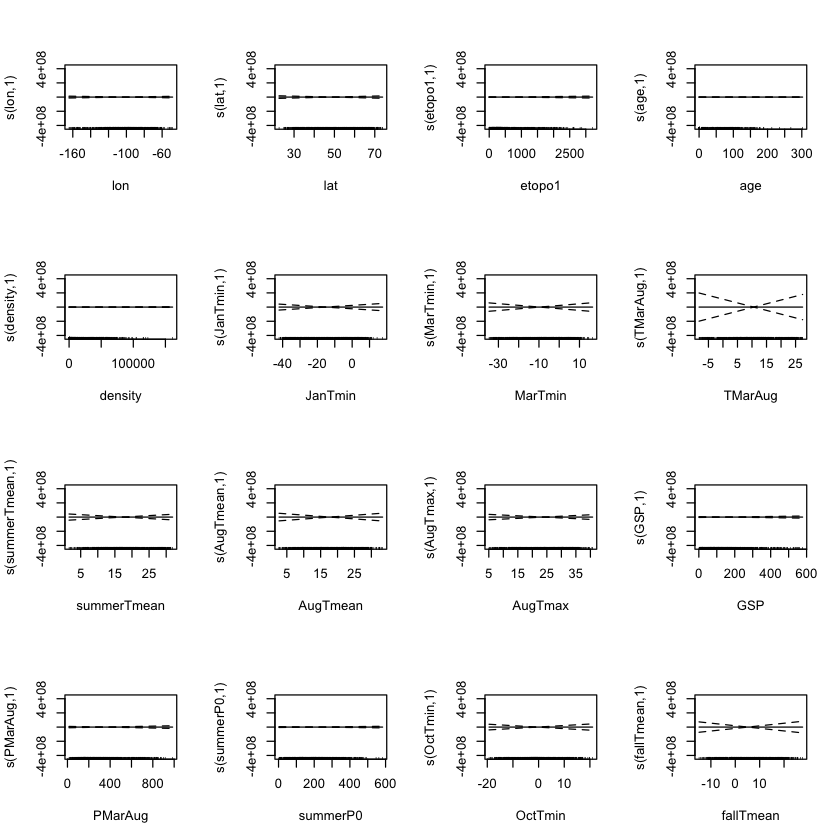

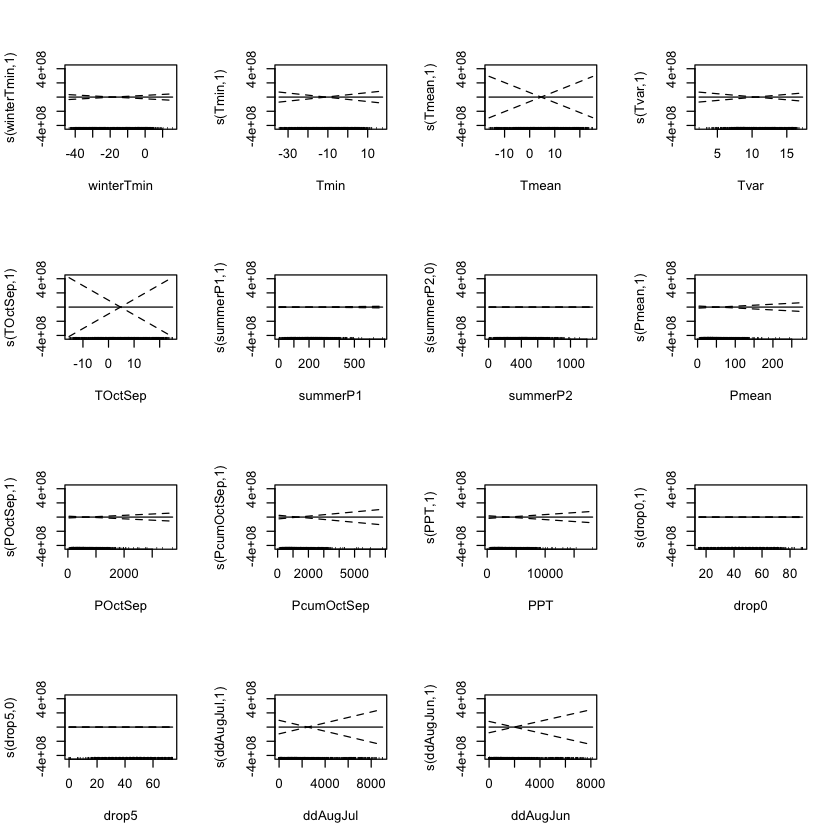

In [46]:
mod <- gam.sample(900)
par(mfrow=c(4, 4))
plot(mod)

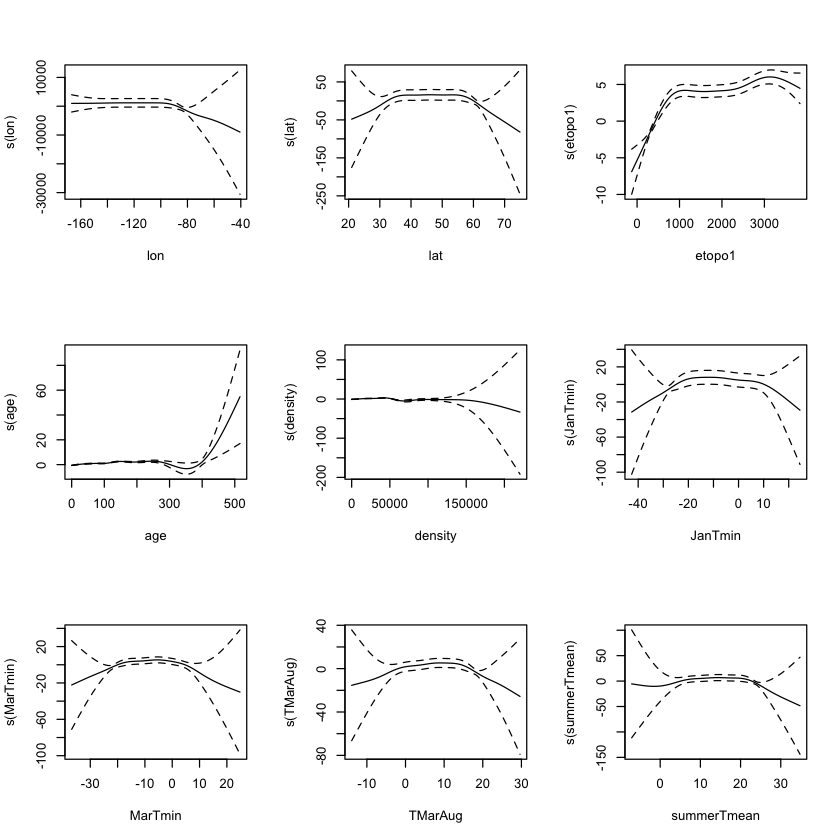

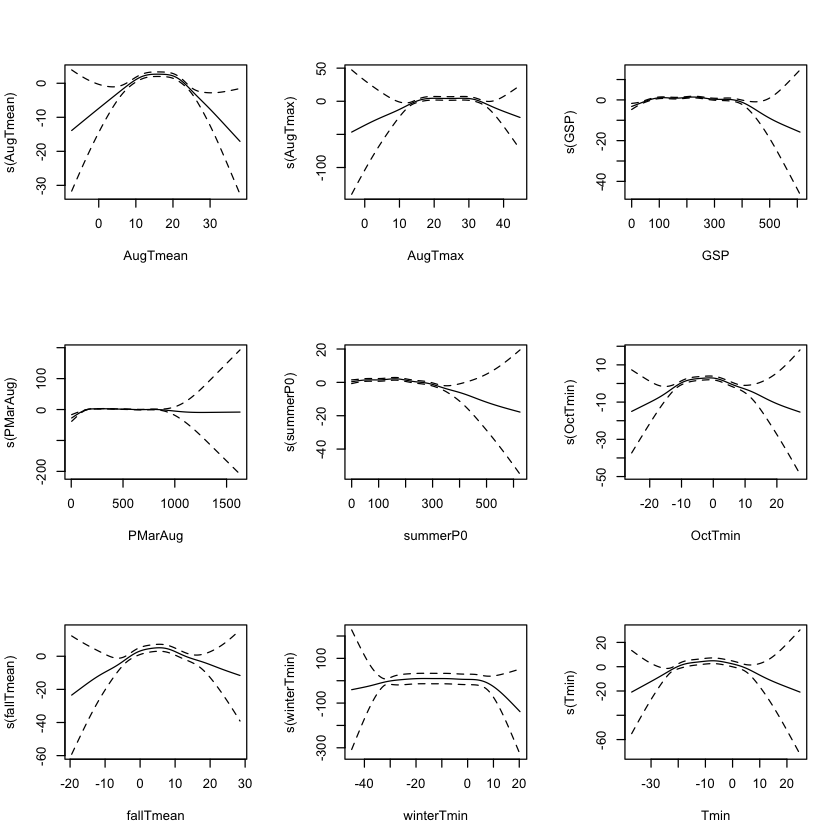

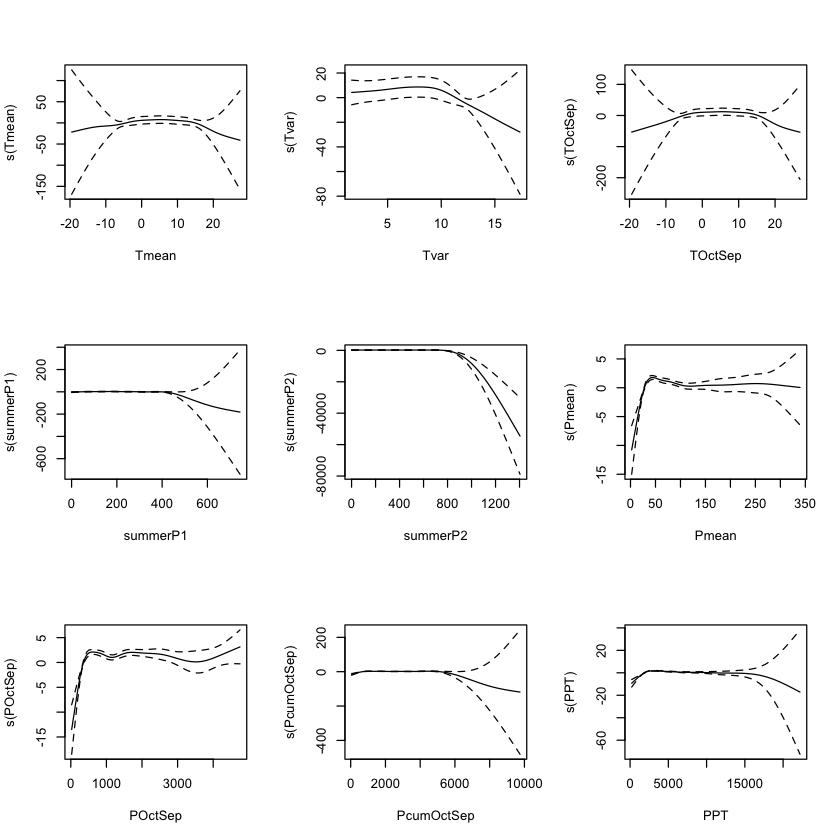

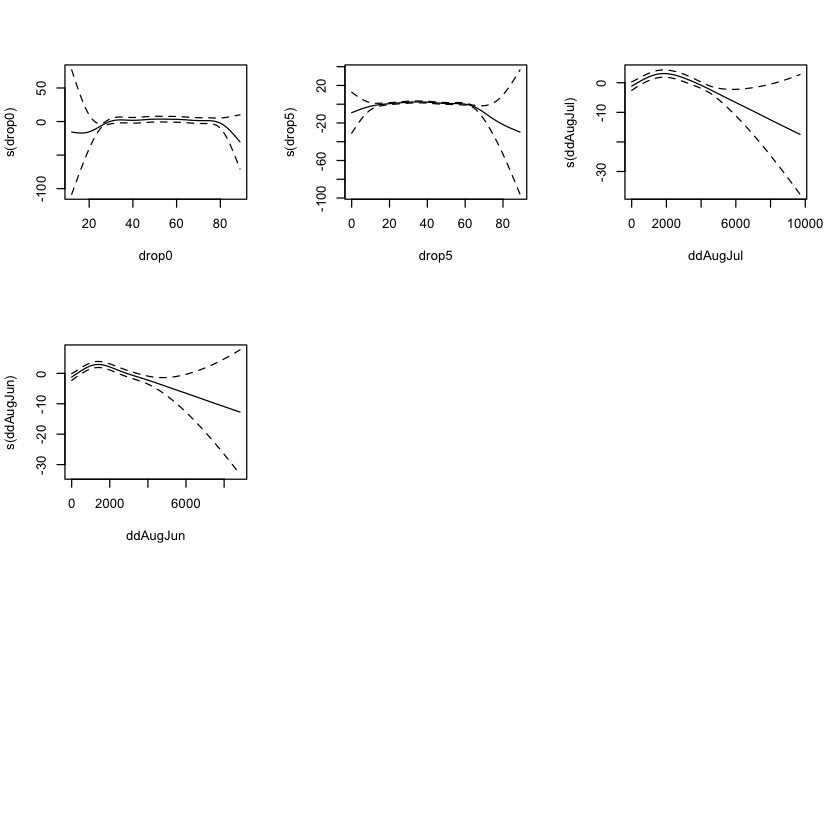

In [69]:
par(mfrow=c(3, 3))
for (field in names(train)) {
  if (!(field %in% ignore)) {
    n <- 1000
    s <- sample(nrow(train), n)
    gam.mod <- gam(train$btl_t[s] ~ s(train[s, field]), family='binomial')
    plot(gam.mod, xlab=field, ylab=paste('s(', field, ')', sep=''))    
  }
}

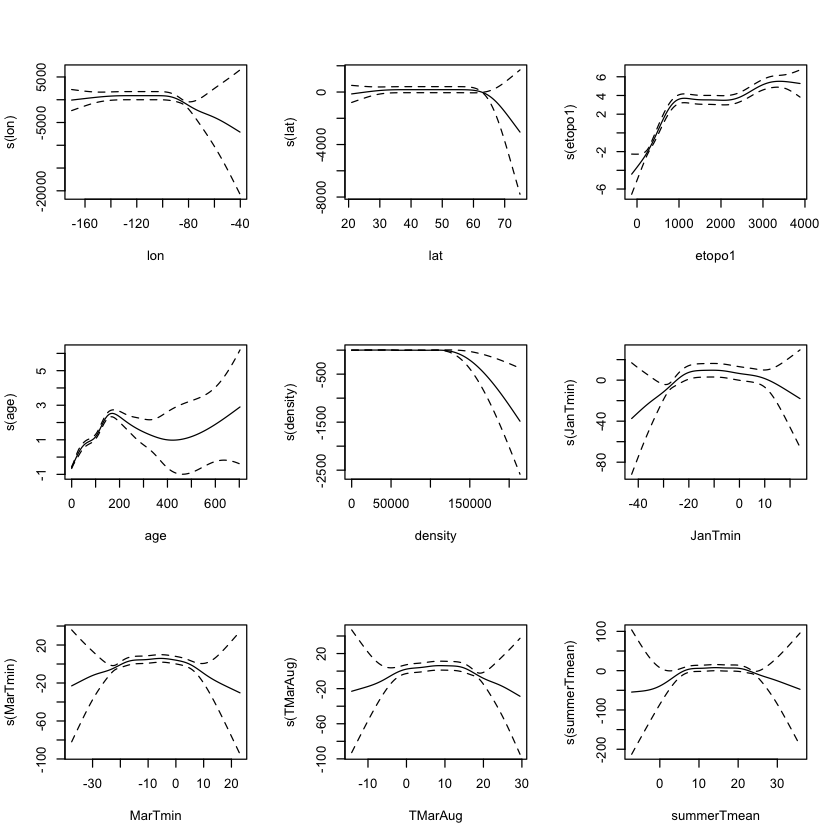

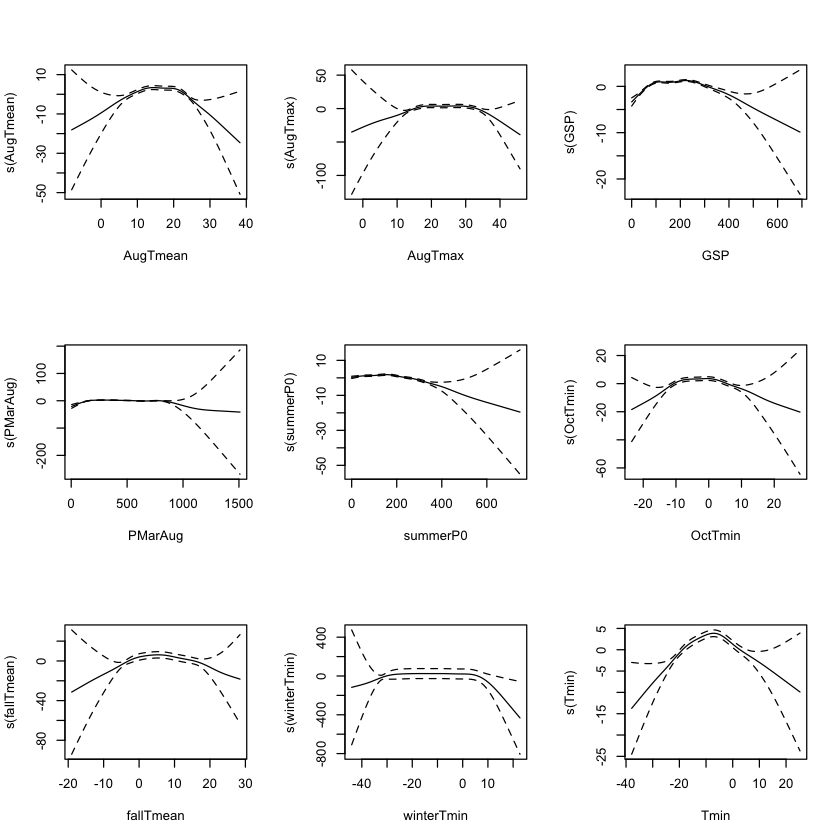

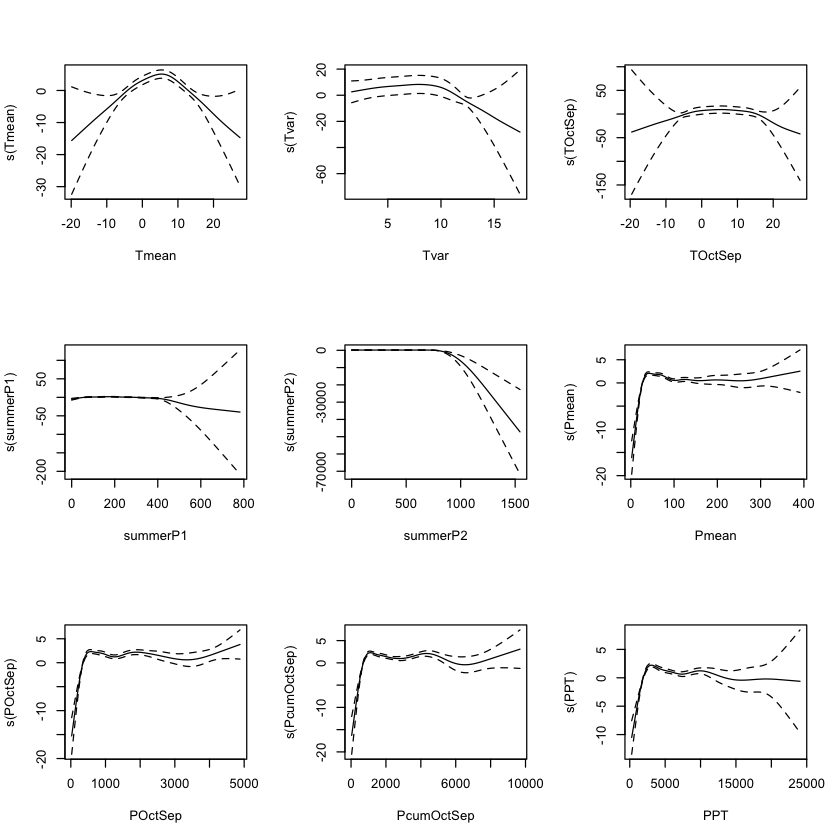

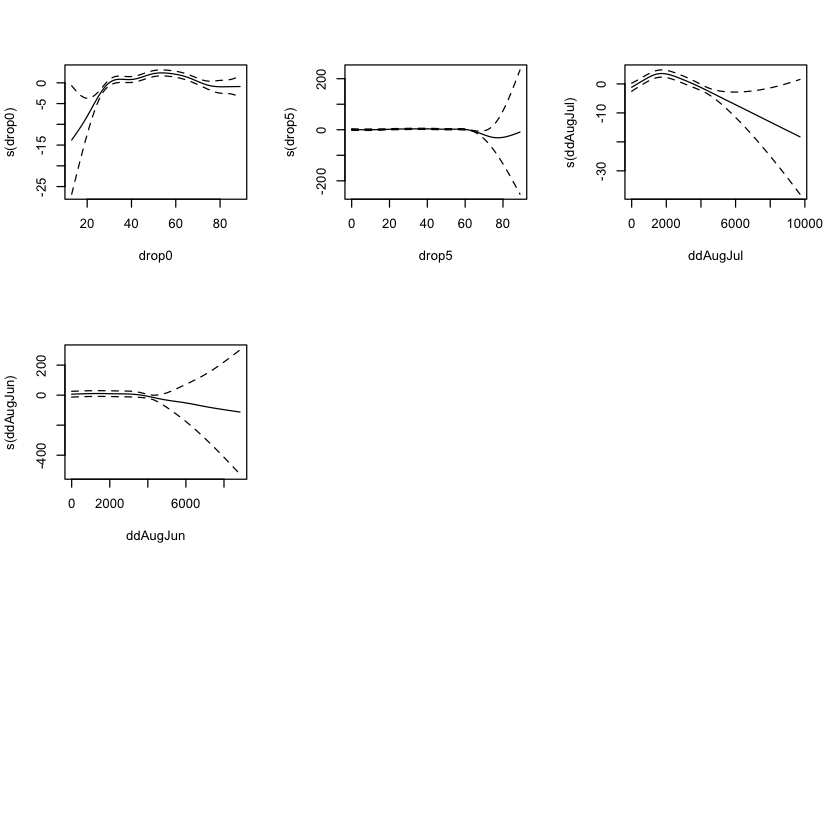

In [70]:
par(mfrow=c(3, 3))
for (field in names(train)) {
  if (!(field %in% ignore)) {
    n <- 32000
    s <- sample(nrow(train), n)
    gam.mod <- gam(train$btl_t[s] ~ s(train[s, field]), family='binomial')
    plot(gam.mod, xlab=field, ylab=paste('s(', field, ')', sep=''))    
  }
}

In [9]:
32000 / nrow(train)

[1] 0.1642542

In [10]:
names(train)

[1] "btl_t"       "x"           "y"           "lon"         "lat"        
 [6] "etopo1"      "btl_t1"      "btl_t2"      "vgt"         "age"        
[11] "density"     "sum9_t1"     "sum9_t2"     "JanTmin"     "MarTmin"    
[16] "TMarAug"     "summerTmean" "AugTmean"    "AugTmax"     "GSP"        
[21] "PMarAug"     "summerP0"    "OctTmin"     "fallTmean"   "winterTmin" 
[26] "Tmin"        "Tmean"       "Tvar"        "TOctSep"     "summerP1"   
[31] "summerP2"    "Pmean"       "POctSep"     "PcumOctSep"  "PPT"        
[36] "drop0"       "drop5"       "ddAugJul"    "ddAugJun"    "year"

In [11]:
mod <- glm(btl_t ~ lon*lat, family='binomial', data=train)
summary(mod)


Call:
glm(formula = btl_t ~ lon * lat, family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3912  -0.2735  -0.1864  -0.0817   2.7878  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.343e+01  6.065e-01  -71.62   <2e-16 ***
lon         -3.834e-01  5.441e-03  -70.46   <2e-16 ***
lat          6.054e-01  9.921e-03   61.02   <2e-16 ***
lon:lat      5.863e-03  8.956e-05   65.47   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 59718  on 194819  degrees of freedom
Residual deviance: 49450  on 194816  degrees of freedom
AIC: 49458

Number of Fisher Scoring iterations: 7


In [13]:
out <- data.frame(f1=c(), f2=c(), p=c())
options(warn=-1)

for (f1 in 4:(ncol(train) - 2)) {
  for (f2 in (f1 + 1):(ncol(train) - 1)) {
    mod <- glm(train$btl_t ~ train[, f1]*train[, f2], family='binomial')
    interaction.p <- summary(mod)$coef[4, 4]
    if (interaction.p < 0.001) {
      row <- data.frame(
          f1=names(train)[f1], f2=names(train)[f2], p=interaction.p) 
      out <- rbind(out, row)
    }
  }
}

options(warn=0)

ERROR: Error in summary(mod)$coef[4, 4]: subscript out of bounds


In [14]:
interactions <- out[order(out$p), ]
dim(interactions)

[1] 537   3

In [15]:
head(interactions)

,f1,f2,p
1,lon,lat,0
6,lon,JanTmin,0
8,lon,TMarAug,0
10,lon,AugTmean,0
11,lon,AugTmax,0
15,lon,OctTmin,0


In [16]:
f1
f2

[1] 36

[1] 37

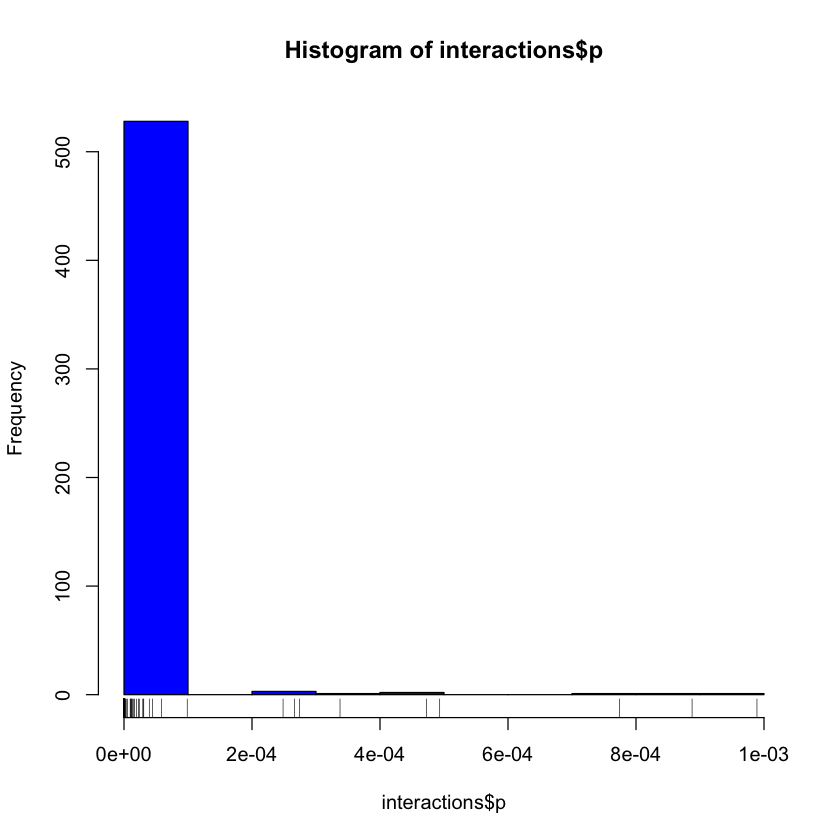

In [17]:
hist(interactions$p, col=4)
rug(interactions$p)

In [18]:
most.important <- interactions[interactions$p == 0, ]
dim(most.important)

[1] 139   3

In [22]:
head(most.important, 10)

,f1,f2,p
1,lon,lat,0
6,lon,JanTmin,0
8,lon,TMarAug,0
10,lon,AugTmean,0
11,lon,AugTmax,0
15,lon,OctTmin,0
16,lon,fallTmean,0
17,lon,winterTmin,0
18,lon,Tmin,0
19,lon,Tmean,0


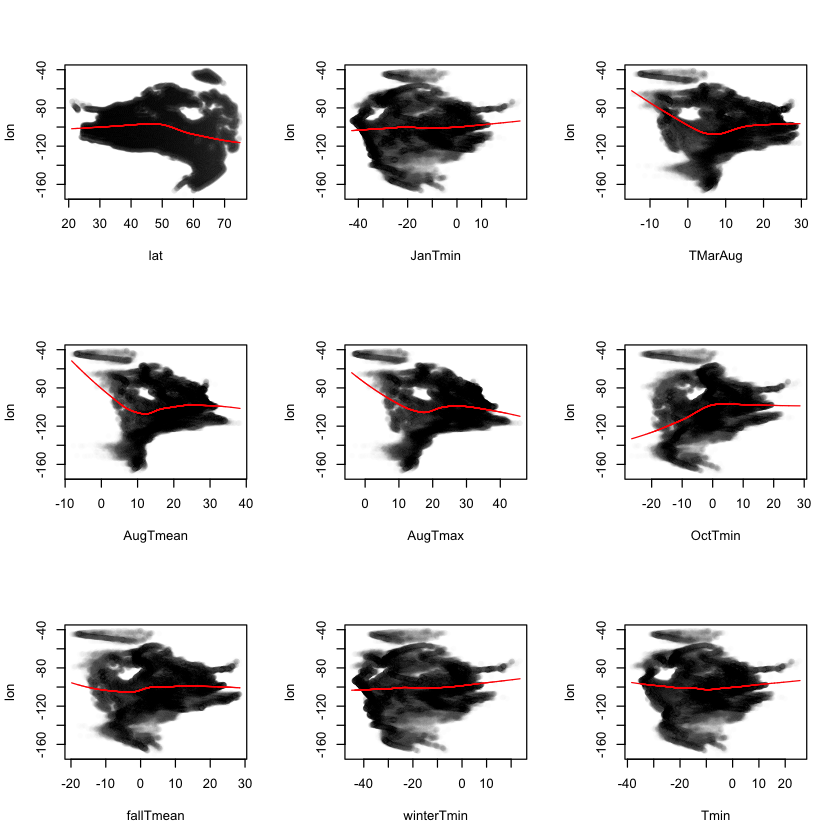

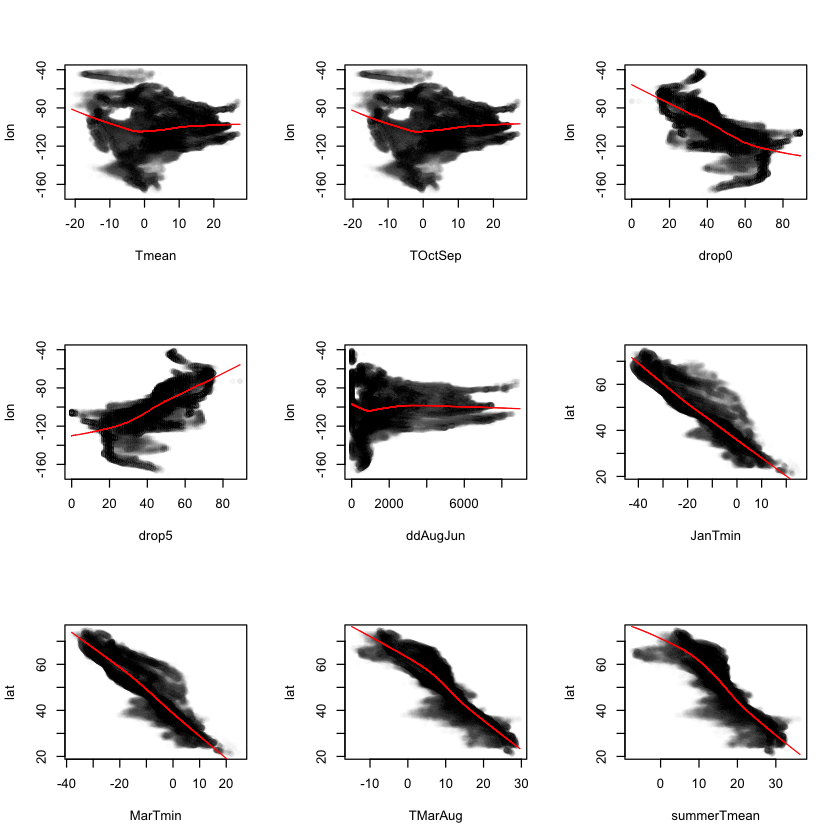

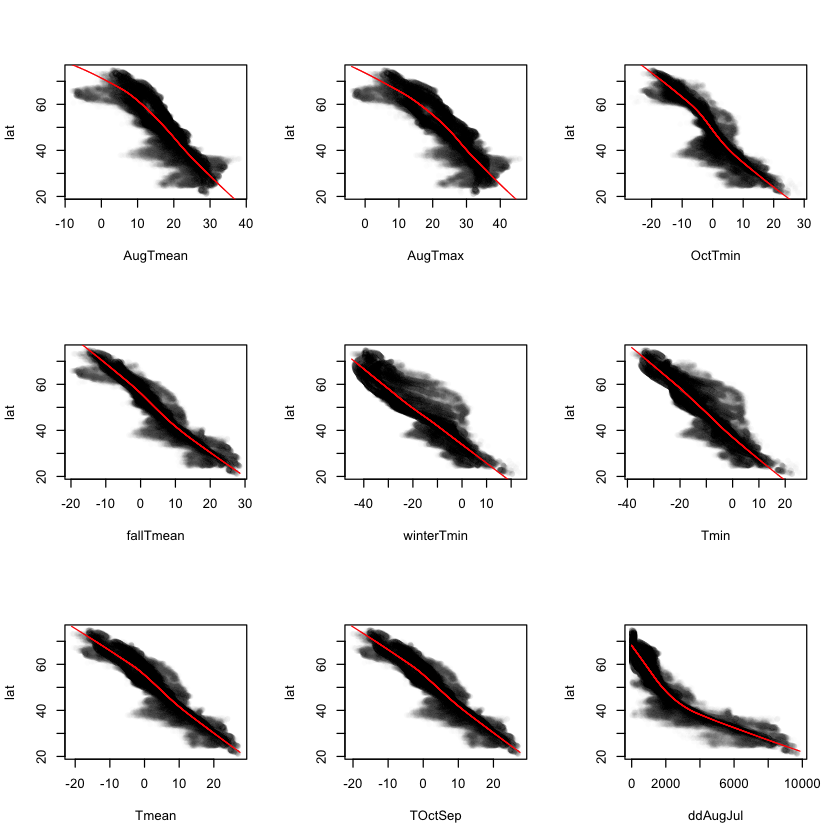

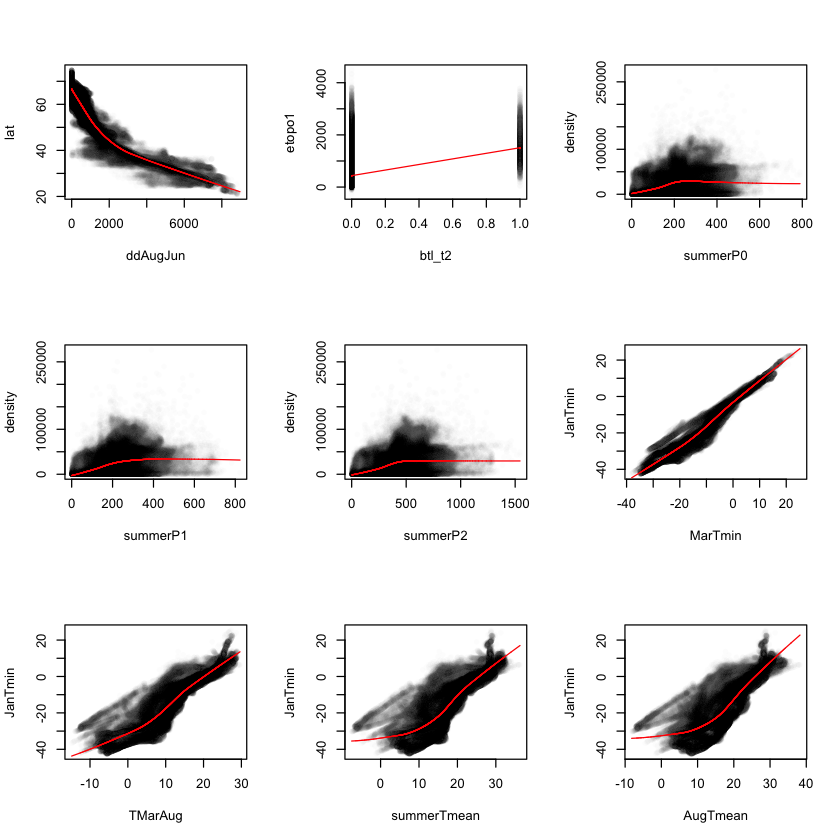

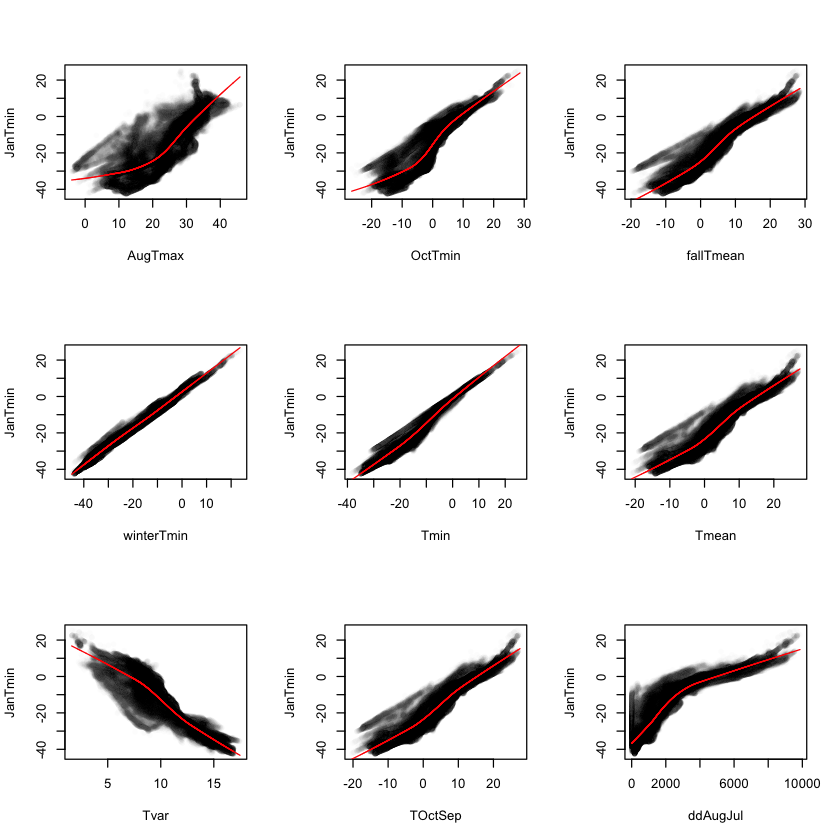

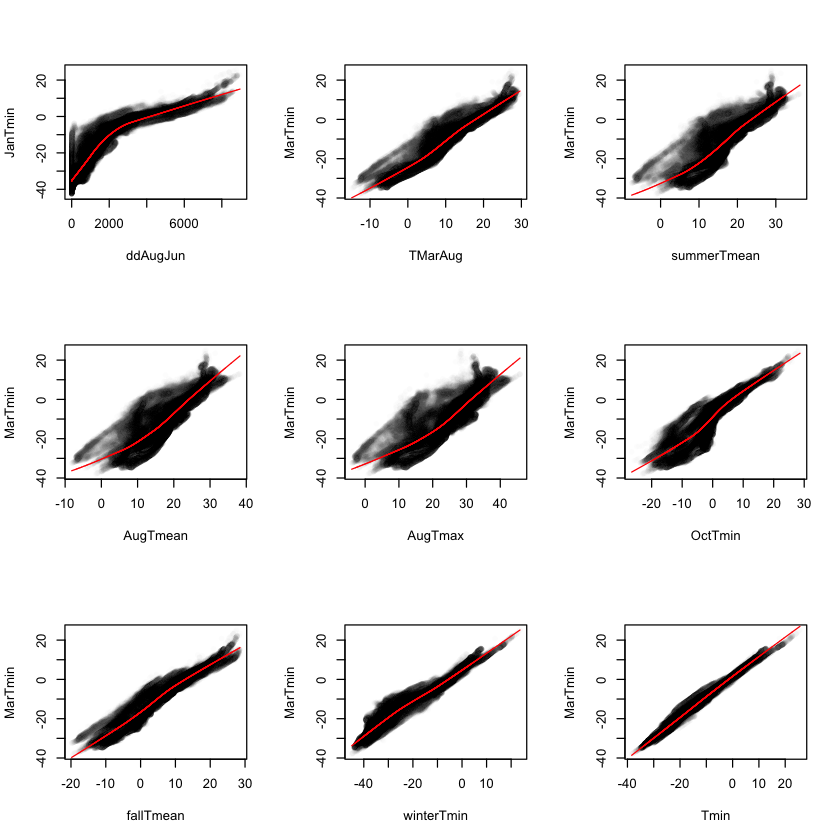

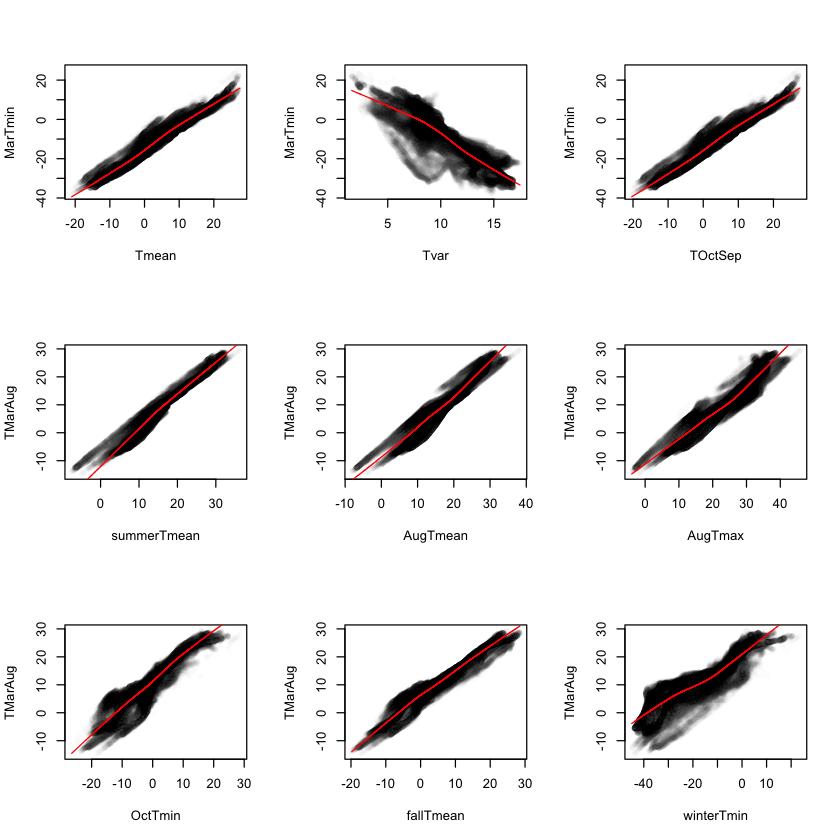

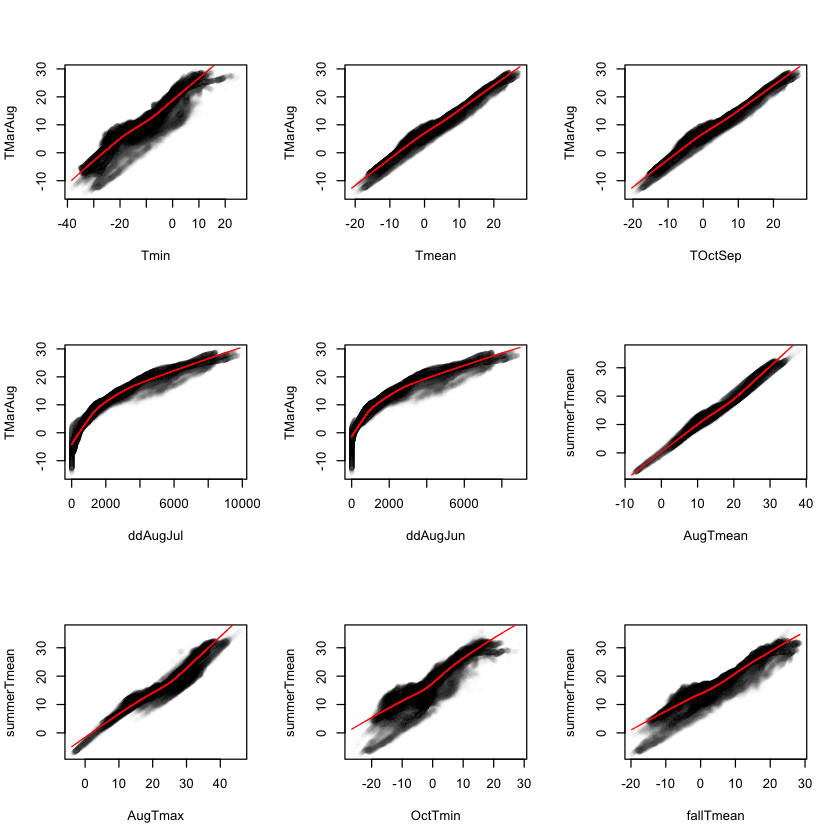

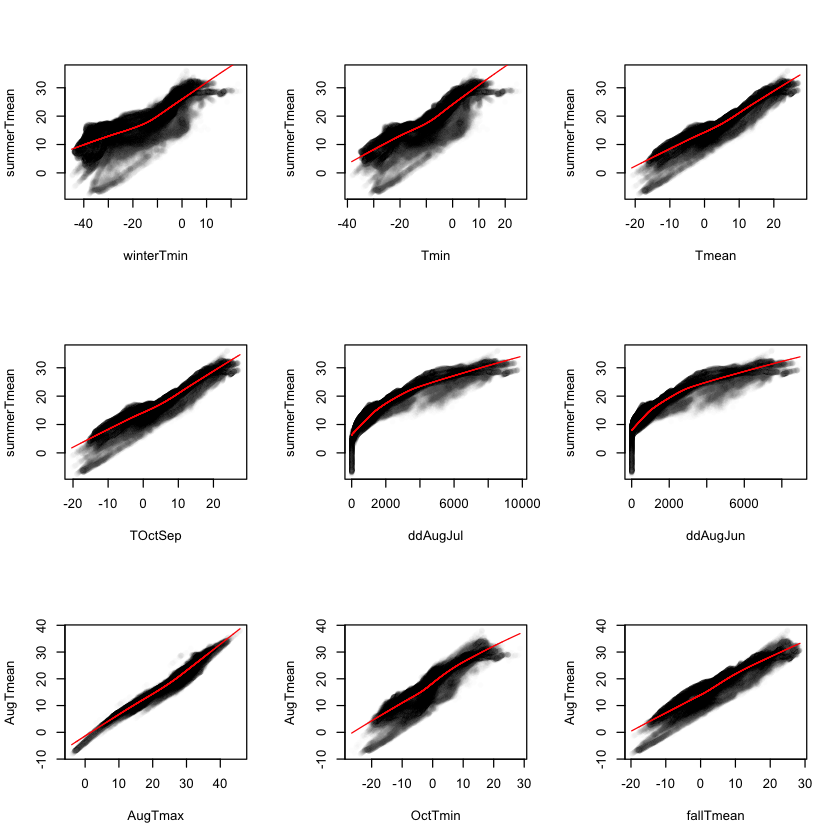

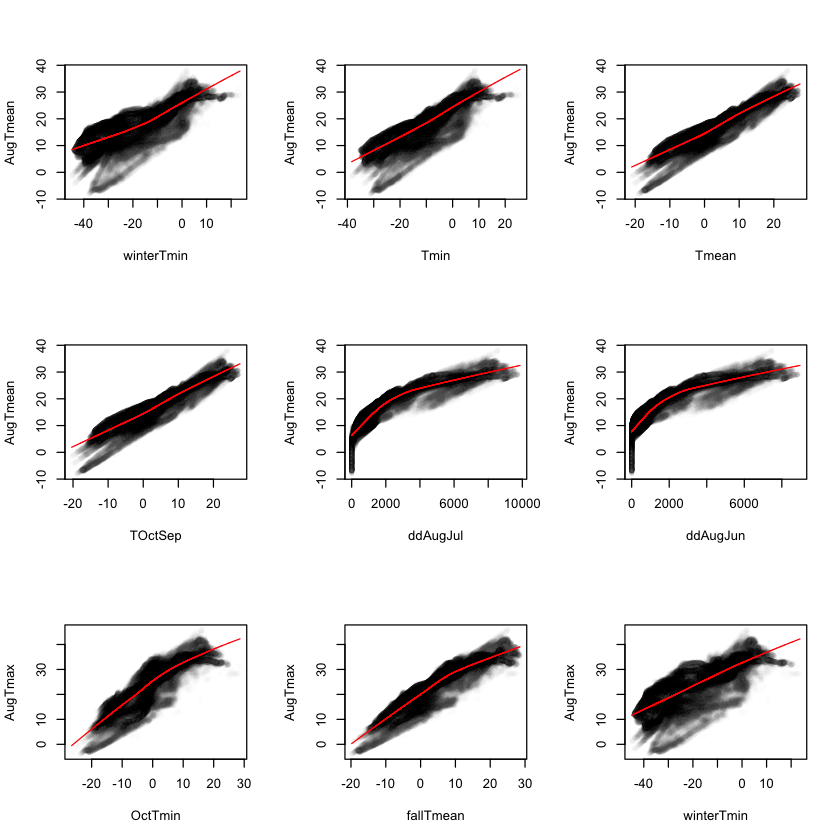

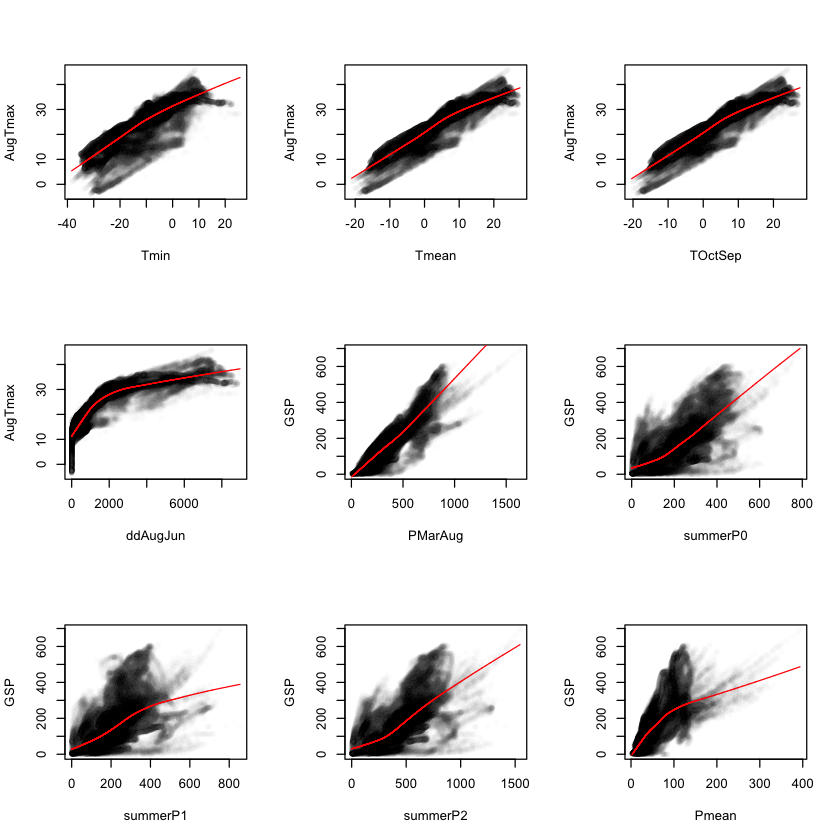

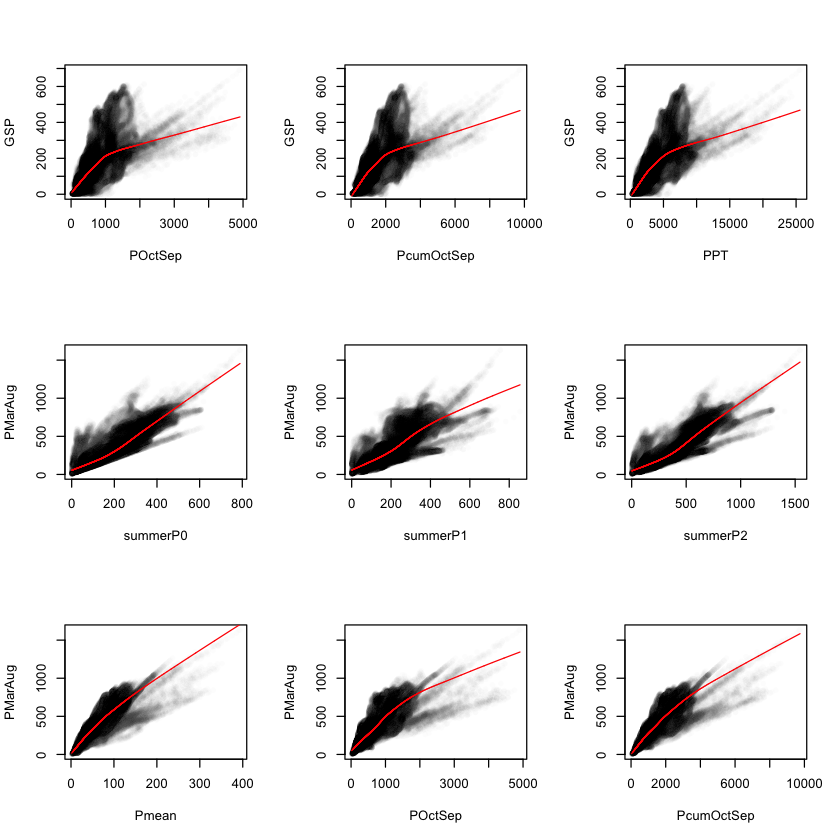

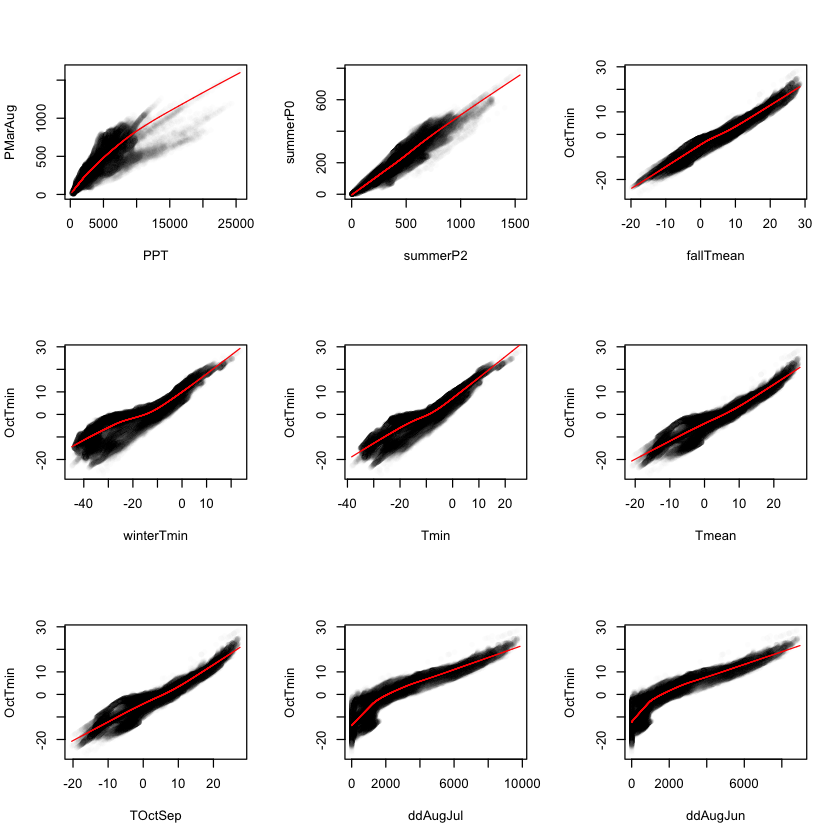

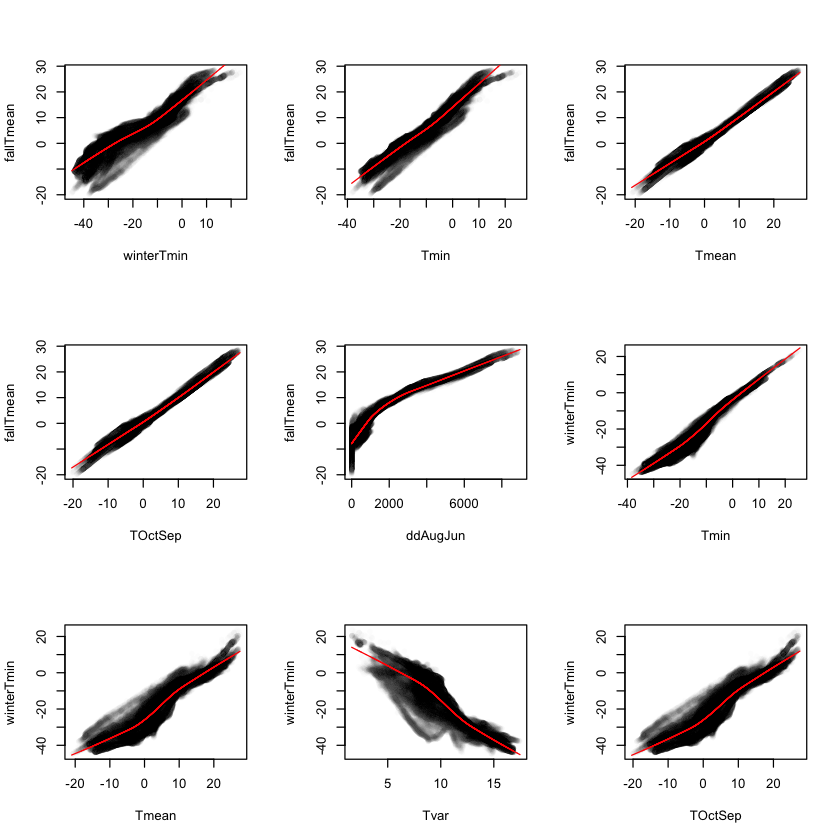

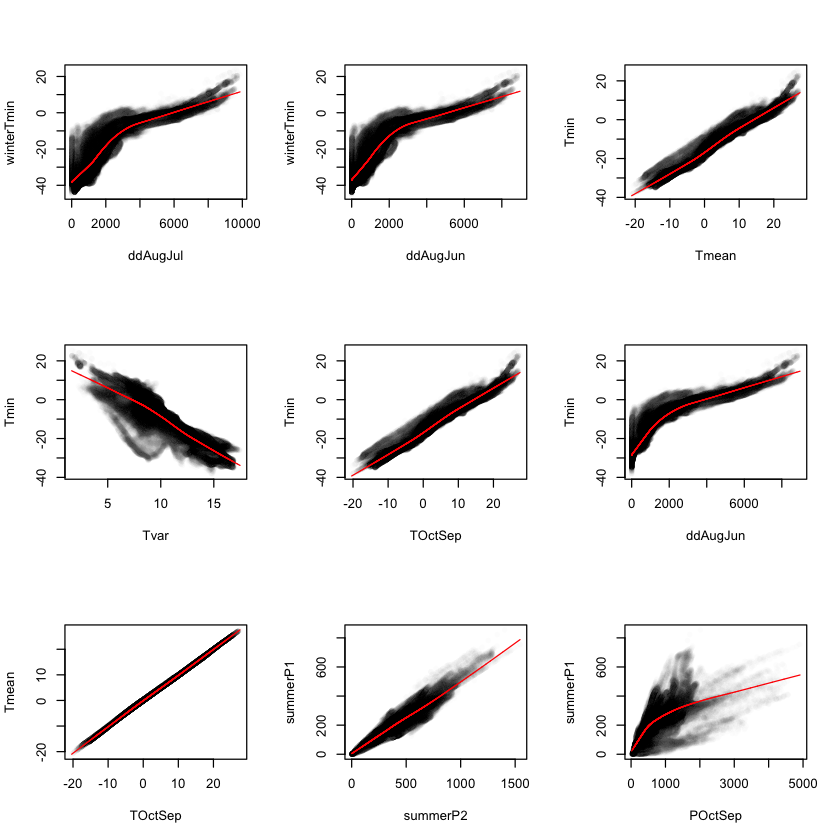

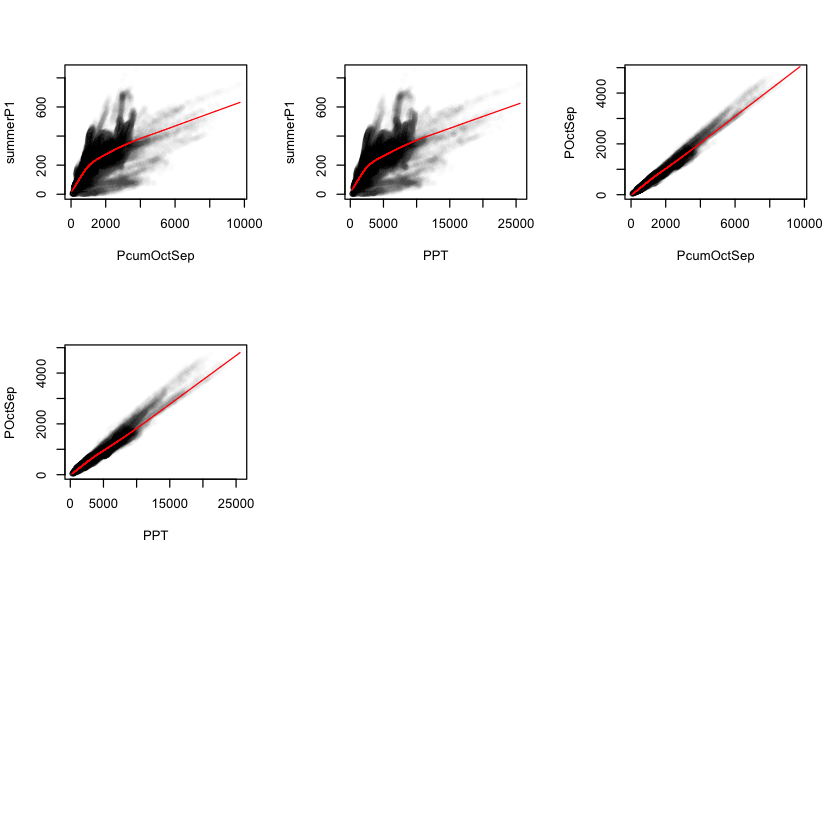

In [34]:
par(mfrow=c(3, 3))
for (i in 1:nrow(most.important)) {
  f1 <- as.character(most.important[i, 1])
  f2 <- as.character(most.important[i, 2])
  has.data <- !(is.na(train[, f1]) | is.na(train[, f2]))
  plot(train[has.data, f1] ~ train[has.data, f2], 
       pch=16, 
       col=rgb(0, 0, 0, 0.01),
       ylab=f1,
       xlab=f2)
  lines(lowess(train[has.data, f1] ~ train[has.data, f2]), col=2)
}